In [88]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from patchify import patchify, unpatchify
import numpy as np
import random
import seaborn as sns

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

## Extracting path for SID dataset

In [20]:
path_to_data = '../data/raw/'
path = path_to_data + 'SIDD_Small_sRGB_Only/Data/'

# This file contains the names of all directory names inside the "Data" directory, 
# which also represent the scene instance names
with open(path_to_data + 'SIDD_Small_sRGB_Only/Scene_Instances.txt') as f:
    instances = f.read()
    
instances = instances.split('\n')
instances[:5]

noisy_images_path = []
gt_images_path = []

for f in instances:
    images_path = path + f + '/'
    
    for g in os.listdir(images_path):
        image_path = images_path + g
        
        if 'NOISY' in image_path:
            noisy_images_path.append(image_path)
        else:
            gt_images_path.append(image_path)
            

print('TOTAL NOISY IMAGES:', len(noisy_images_path))
print('TOTAL GROUND TRUTH IMAGES:', len(gt_images_path))

TOTAL NOISY IMAGES: 160
TOTAL GROUND TRUTH IMAGES: 160


In [21]:
df_SIDD = pd.DataFrame()
df_SIDD['Ground Truth Images'] = gt_images_path
df_SIDD['Noisy Images'] = noisy_images_path
df_SIDD.head()

Ground Truth Images  \
0  ../data/raw/SIDD_Small_sRGB_Only/Data/0001_001...   
1  ../data/raw/SIDD_Small_sRGB_Only/Data/0002_001...   
2  ../data/raw/SIDD_Small_sRGB_Only/Data/0003_001...   
3  ../data/raw/SIDD_Small_sRGB_Only/Data/0004_001...   
4  ../data/raw/SIDD_Small_sRGB_Only/Data/0005_001...   

                                        Noisy Images  
0  ../data/raw/SIDD_Small_sRGB_Only/Data/0001_001...  
1  ../data/raw/SIDD_Small_sRGB_Only/Data/0002_001...  
2  ../data/raw/SIDD_Small_sRGB_Only/Data/0003_001...  
3  ../data/raw/SIDD_Small_sRGB_Only/Data/0004_001...  
4  ../data/raw/SIDD_Small_sRGB_Only/Data/0005_001...

In [24]:
df_SIDD.shape

# Concatinate new data to df
df = df_SIDD

## TODO: Add Renoir dataset

## EDA

### Image Sizes

In [25]:
size=[]
for i in range(len(df)):
  img_gt = cv2.imread(df['Ground Truth Images'].iloc[i])
  size.append(img_gt.shape)

In [26]:
df['image size'] = size
df['image size'] = df['image size'].astype(str)
df.head()

Ground Truth Images  \
0  ../data/raw/SIDD_Small_sRGB_Only/Data/0001_001...   
1  ../data/raw/SIDD_Small_sRGB_Only/Data/0002_001...   
2  ../data/raw/SIDD_Small_sRGB_Only/Data/0003_001...   
3  ../data/raw/SIDD_Small_sRGB_Only/Data/0004_001...   
4  ../data/raw/SIDD_Small_sRGB_Only/Data/0005_001...   

                                        Noisy Images       image size  
0  ../data/raw/SIDD_Small_sRGB_Only/Data/0001_001...  (3000, 5328, 3)  
1  ../data/raw/SIDD_Small_sRGB_Only/Data/0002_001...  (3000, 5328, 3)  
2  ../data/raw/SIDD_Small_sRGB_Only/Data/0003_001...  (3000, 5328, 3)  
3  ../data/raw/SIDD_Small_sRGB_Only/Data/0004_001...  (3000, 5328, 3)  
4  ../data/raw/SIDD_Small_sRGB_Only/Data/0005_001...  (3000, 5328, 3)

Text(0, 0.5, 'No. of images')

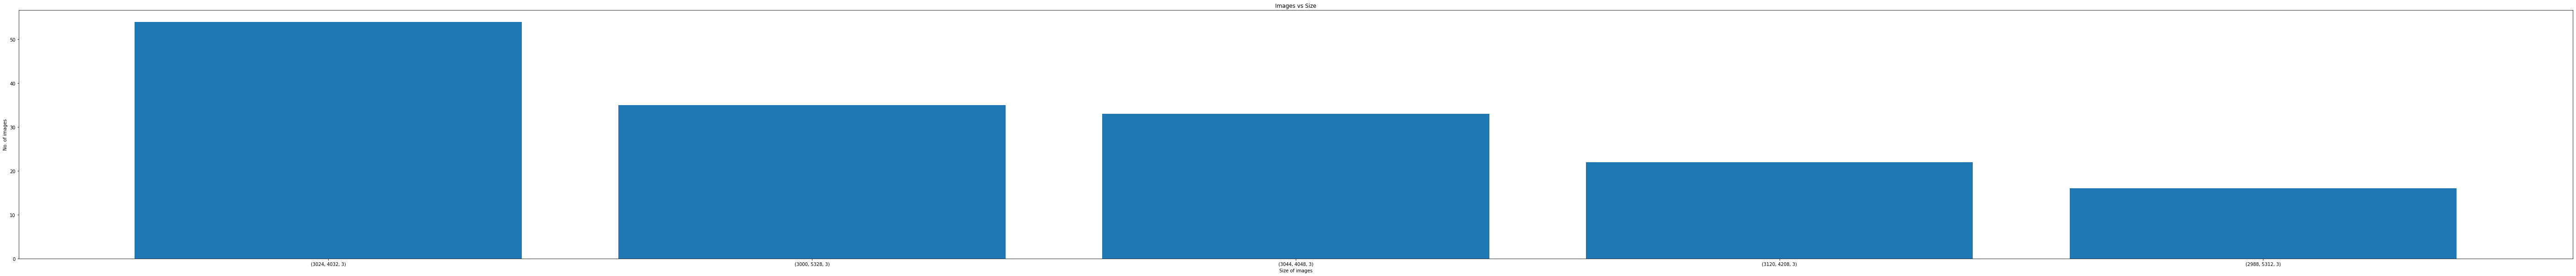

In [28]:
fig = plt.figure(figsize = (100, 10))
y = list(df['image size'].value_counts())
x = df['image size'].value_counts().index.tolist()
plt.bar(x,y)
plt.title("Images vs Size")
plt.xlabel("Size of images")
plt.ylabel("No. of images")

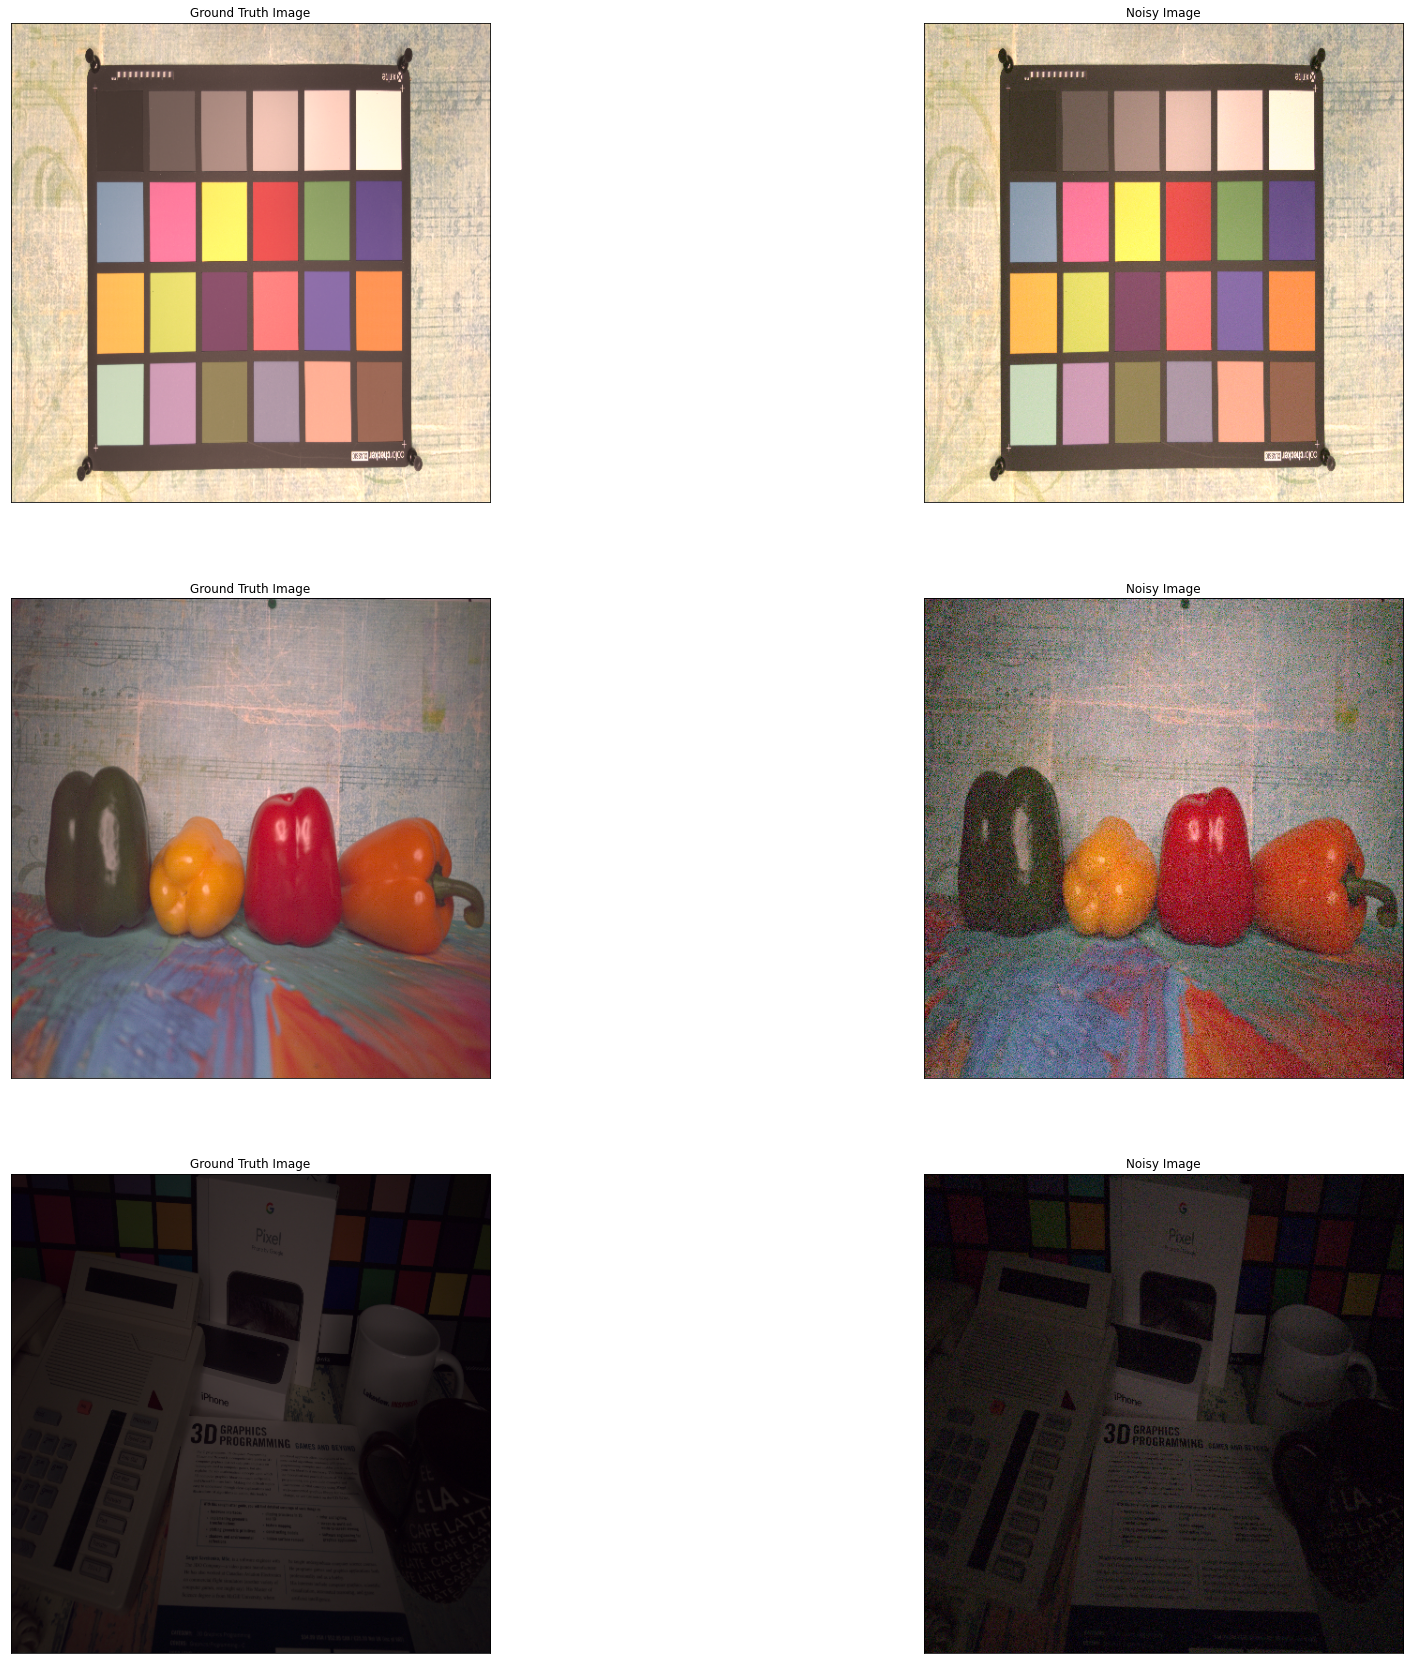

In [29]:
sample = df.sample(3)
fig, ax = plt.subplots(len(sample),2,figsize=(30,30))
for i in range(len(sample)):
  img = cv2.imread(sample['Ground Truth Images'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][0].imshow(img)
  ax[i][0].get_xaxis().set_visible(False)
  ax[i][0].get_yaxis().set_visible(False)
  ax[i][0].title.set_text("Ground Truth Image")
  
  img = cv2.imread(sample['Noisy Images'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][1].imshow(img)
  ax[i][1].get_xaxis().set_visible(False)
  ax[i][1].get_yaxis().set_visible(False)
  ax[i][1].title.set_text("Noisy Image")

## Splitting the dataset into train and test datasets

In [32]:
X = df['Noisy Images']
y = df['Ground Truth Images']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
# Storing the image paths as pickle files
import pickle
pickle.dump((X_train,y_train),open("../data/interim/" + 'train_path.pkl','wb'))
pickle.dump((X_test,y_test),open("../data/interim/" + 'test_path.pkl','wb'))

In [34]:
X_train, y_train = pickle.load(open("../data/interim/" + 'train_path.pkl', 'rb'))
X_test,y_test = pickle.load(open("../data/interim/" + 'test_path.pkl', 'rb'))

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(128,)
(128,)
(32,)
(32,)


In [38]:
# Creating patches from the images
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

In [47]:
#Creating patches for X_train and y_train
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_train images
  patches_nsy = patches(img_nsy,256)
  
  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_train images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(patches_gt[j][k][0])
  
X_train = np.array(X_train_patches)
y_train = np.array(y_train_patches)

In [48]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_test images
  patches_nsy = patches(img_nsy,256)
  
  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_test images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(patches_gt[j][k][0])

X_test = np.array(X_test_patches)
y_test = np.array(y_test_patches)

In [49]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2048, 256, 256, 3)
(2048, 256, 256, 3)
(512, 256, 256, 3)
(512, 256, 256, 3)


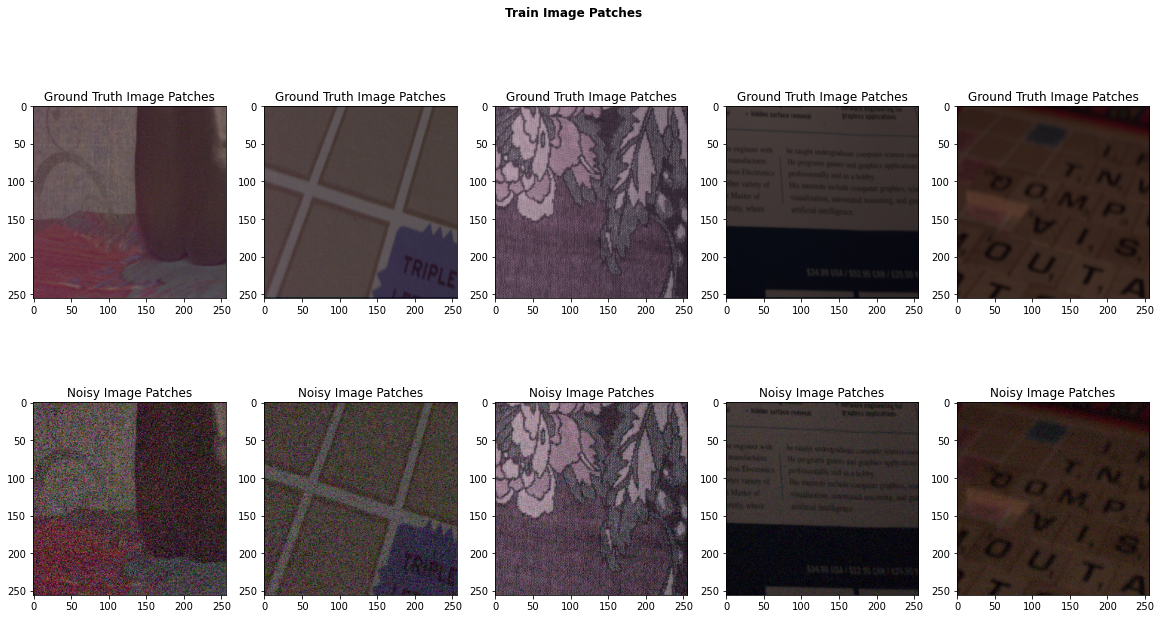

In [53]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, 2048), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_train[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_train[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

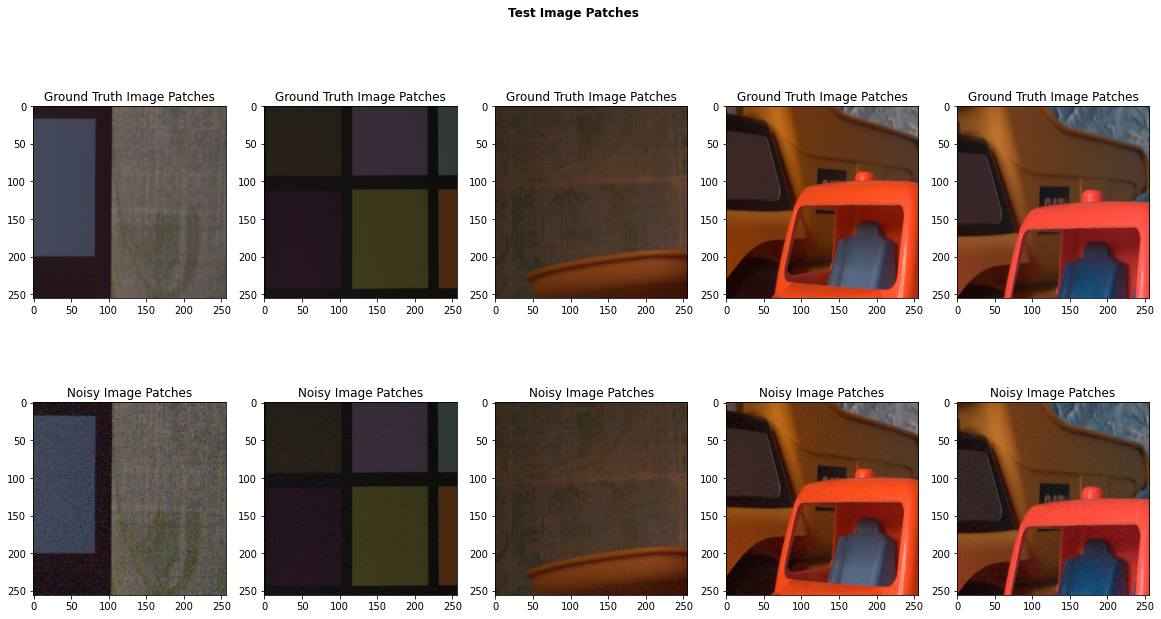

In [54]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, 512), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_test[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [55]:
print("Total number of image patches on train data : ", len(X_train))
print("Total number of image patches on test data : ", len(X_test))

Total number of image patches on train data :  2048
Total number of image patches on test data :  512


In [56]:
#Storing the image patches as pickle files
import pickle
pickle.dump((X_train,y_train),open("../data/interim/" + 'train_data.pkl','wb'))
pickle.dump((X_test,y_test),open("../data/interim/" + 'test_data.pkl','wb'))

## Distribution of mean pixels of image


In [57]:
mean_red_gt = []
mean_blue_gt = []
mean_green_gt = []
mean_red_nsy = []
mean_blue_nsy = []
mean_green_nsy = []
for path in df['Ground Truth Images']:
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mean_red_gt.append(np.mean(img[:,:,0]))
  mean_green_gt.append(np.mean(img[:,:,1]))
  mean_blue_gt.append(np.mean(img[:,:,2]))

for path in df['Noisy Images']:
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mean_red_nsy.append(np.mean(img[:,:,0]))
  mean_green_nsy.append(np.mean(img[:,:,1]))
  mean_blue_nsy.append(np.mean(img[:,:,2]))

In [62]:
red_gt = pd.DataFrame()
green_gt = pd.DataFrame()
blue_gt = pd.DataFrame()
red_nsy = pd.DataFrame()
green_nsy = pd.DataFrame()
blue_nsy = pd.DataFrame()

red_gt['Mean Pixel on Ground Truth Images'] = mean_red_gt
red_gt['channel'] = 'red'
red_nsy['Mean Pixel on  Noisy Images'] = mean_red_nsy
red_nsy['channel'] = 'red'

green_gt['Mean Pixel on Ground Truth Images'] = mean_green_gt
green_gt['channel'] = 'green'
green_nsy['Mean Pixel on  Noisy Images'] = mean_green_nsy
green_nsy['channel'] = 'green'

blue_gt['Mean Pixel on Ground Truth Images'] = mean_blue_gt
blue_gt['channel'] = 'blue'
blue_nsy['Mean Pixel on  Noisy Images'] = mean_blue_nsy
blue_nsy['channel'] = 'blue'

concat_gt = pd.concat([red_gt,green_gt,blue_gt],ignore_index=True)
concat_nsy = pd.concat([red_nsy,green_nsy,blue_nsy],ignore_index=True)

/Users/milindsoorya/miniforge3/envs/dino_ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/milindsoorya/miniforge3/envs/dino_ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/milindsoorya/miniforge3/envs/dino_ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

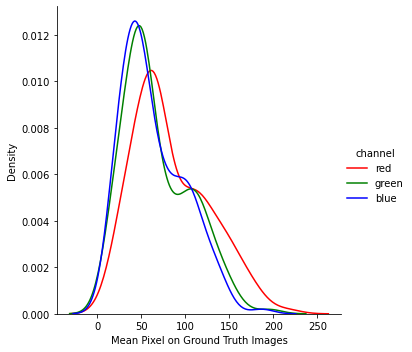

In [66]:
color = {'color': ['r', 'g', 'b']}
sns.FacetGrid(concat_gt,hue='channel',height=5,hue_kws=color).map(sns.distplot,'Mean Pixel on Ground Truth Images',hist=False).add_legend()

/Users/milindsoorya/miniforge3/envs/dino_ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/milindsoorya/miniforge3/envs/dino_ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/milindsoorya/miniforge3/envs/dino_ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

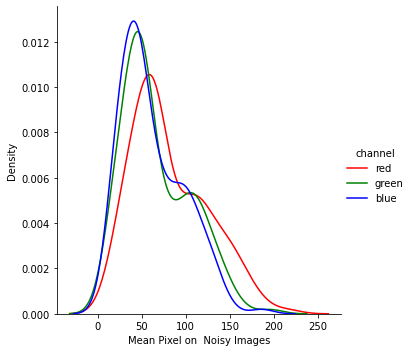

In [68]:
sns.FacetGrid(concat_nsy,hue='channel',height=5,hue_kws=color).map(sns.distplot,'Mean Pixel on  Noisy Images',hist=False).add_legend()

Observations : For most of the images (both clean and noisy), the mean pixel values ranges between 0 - 100. This means, most of the images have dark to medium brightness. Only few images have high mean pixel values or high brightness.   

## Analyzing the pixel distribution on few clean-noisy image pairs by ploting histograms 

In [83]:
## TODO: A function to select random images

sample = pd.DataFrame({
    'Ground Truth Images' : [
        '../data/raw/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG',
         '../data/raw/SIDD_Small_sRGB_Only/Data/0057_003_G4_00100_00125_5500_L/GT_SRGB_010.PNG'],
    'Noisy Images' : [
        '../data/raw/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG',
         '../data/raw/SIDD_Small_sRGB_Only/Data/0057_003_G4_00100_00125_5500_L/NOISY_SRGB_010.PNG']
 })


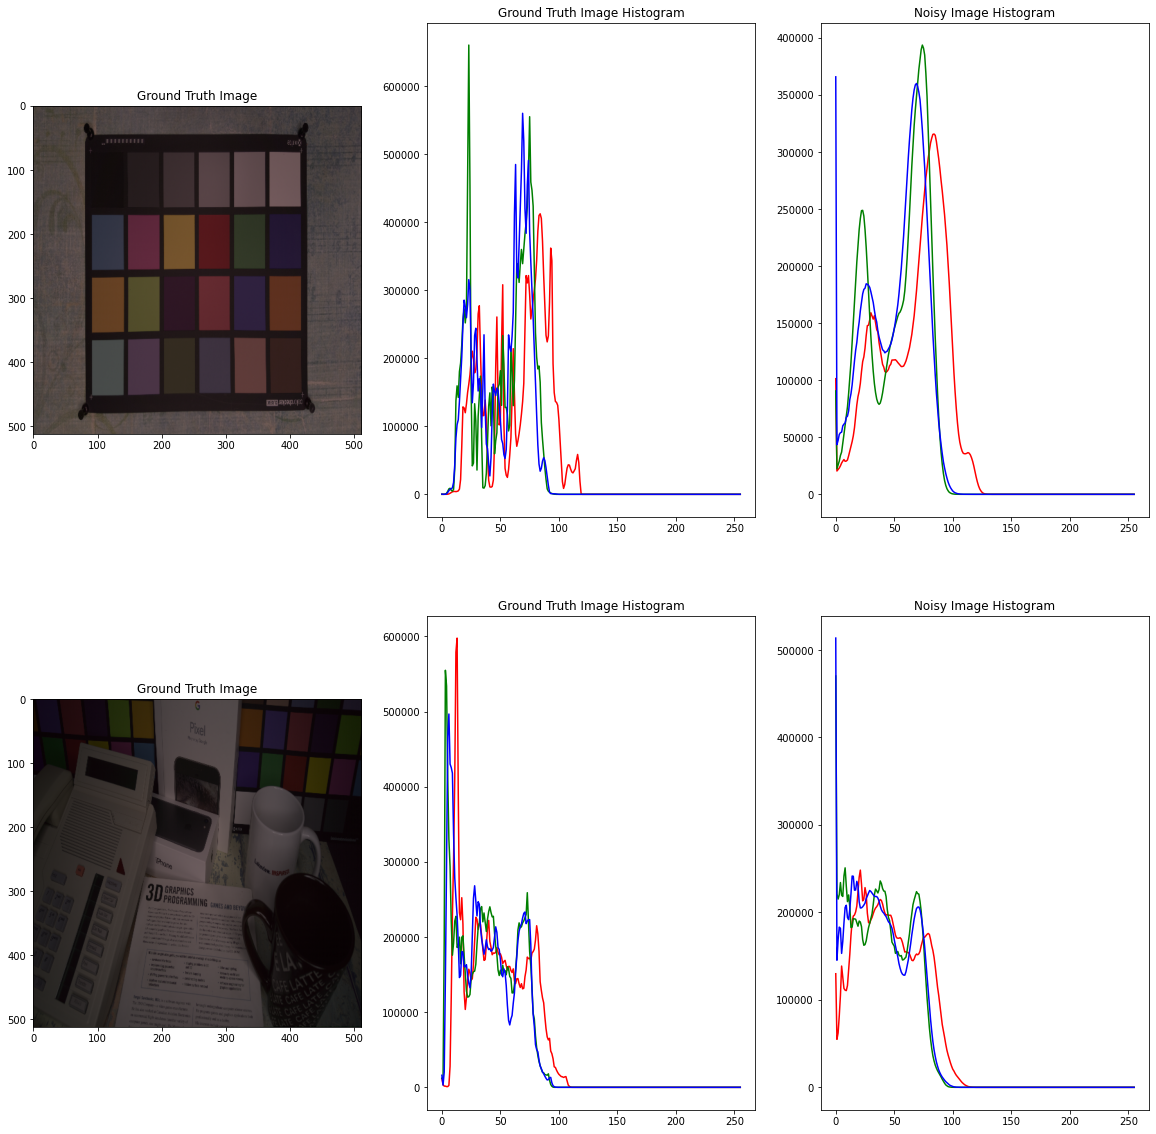

In [84]:
#https://www.geeksforgeeks.org/opencv-python-program-analyze-image-using-histogram/
fig, axes = plt.subplots(len(sample),3,figsize=(20, 20))
for i in range(len(sample)):
  path = sample['Ground Truth Images'].iloc[i]
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resized_img = cv2.resize(img,(512,512))
  axes[i][0].imshow(resized_img)
  axes[i][0].set_title('Ground Truth Image')
  axes[i][1].plot(cv2.calcHist([img],[0],None,[256],[0,256]),color='r')
  axes[i][1].plot(cv2.calcHist([img],[1],None,[256],[0,256]),color='g')
  axes[i][1].plot(cv2.calcHist([img],[2],None,[256],[0,256]),color='b')
  axes[i][1].set_title('Ground Truth Image Histogram')

  path = sample['Noisy Images'].iloc[i]
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i][2].plot(cv2.calcHist([img],[0],None,[256],[0,256]),color='r')
  axes[i][2].plot(cv2.calcHist([img],[1],None,[256],[0,256]),color='g')
  axes[i][2].plot(cv2.calcHist([img],[2],None,[256],[0,256]),color='b')
  axes[i][2].set_title('Noisy Image Histogram')

Observation : The noisy images seems to have smoother pixel intensity distribution compared to clean images. Also many pixels in noisy images takes zero pixel value compared to the corresponding pixel values of its clean image. 

## Analyzing the PSNR and SSIM values of the images

In [89]:
from tqdm import tqdm
SSIM = [];PSNR = [];
for i in tqdm(range(len(df))):
  path = df['Ground Truth Images'].iloc[i]
  img1 = cv2.imread(path)
  img1 = img1.astype("float32") / 255.0
  path = df['Noisy Images'].iloc[i]
  img2 = cv2.imread(path)
  img2 = img2.astype("float32") / 255.0
  SSIM.append(ssim(img1,img2,multichannel=True,data_range=img2.max() - img2.min()))
  PSNR.append(psnr(img1,img2))

  0%|          | 0/160 [00:00<?, ?it/s]/var/folders/z0/vtybv08x04v0yvjn33rylfmw0000gn/T/ipykernel_30996/1242567100.py:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  SSIM.append(ssim(img1,img2,multichannel=True,data_range=img2.max() - img2.min()))
100%|██████████| 160/160 [08:37<00:00,  3.24s/it]


In [91]:
np.save('../data/interim/SSIM.npy', SSIM)
np.save('../data/interim/PSNR.npy', PSNR)

In [93]:
# To load the arrays
SSIM = np.load('../data/interim/SSIM.npy', allow_pickle=True)
PSNR = np.load('../data/interim/PSNR.npy', allow_pickle=True)

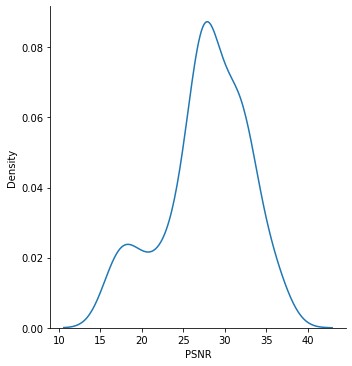

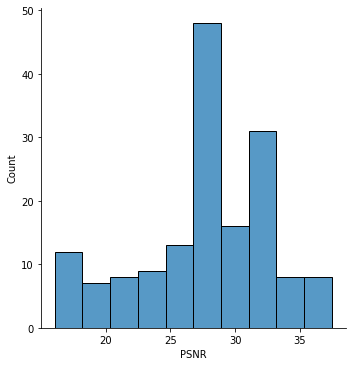

In [95]:
ax = sns.displot(PSNR,kind='kde')
ax.set(xlabel='PSNR', ylabel='Density')
ax = sns.displot(PSNR)
ax.set(xlabel='PSNR', ylabel='Count')

Observations : Majority of the clean-noisy image pairs have PSNR value between 25-30. So, a good denoising model should give PSNR value greater than 30 (approx) for majority of the images.

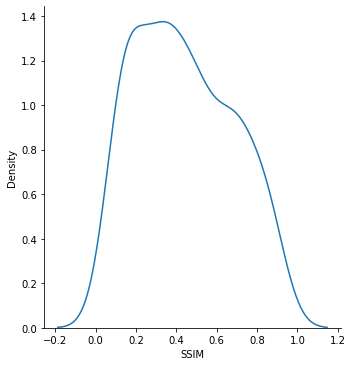

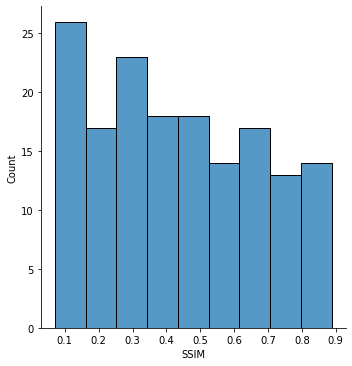

In [96]:
ax = sns.displot(SSIM,kind='kde')
ax.set(xlabel='SSIM', ylabel='Density')
ax = sns.displot(SSIM)
ax.set(xlabel='SSIM', ylabel='Count')

## Denoising few image patches using NLM filter 

Before we jump into using deep learning models for denoising, lets look at how a simple denoising method known as Non Local Means (NLM) performs in denoising few image patches. <br>

We will take few image patches and apply NLM filter on them for denoising and visualize these denoised images. This will help us understand the need of using more advanced deep learning techniques for denosing tasks. <br>

Non-local means is an algorithm in image processing for image denoising. Unlike "local mean" filters, which take the mean value of a group of pixels surrounding a target pixel to smooth the image, non-local means filtering takes a mean of all pixels in the image, weighted by how similar these pixels are to the target pixel. This results in much greater post-filtering clarity, and less loss of detail in the image compared with local mean algorithms.

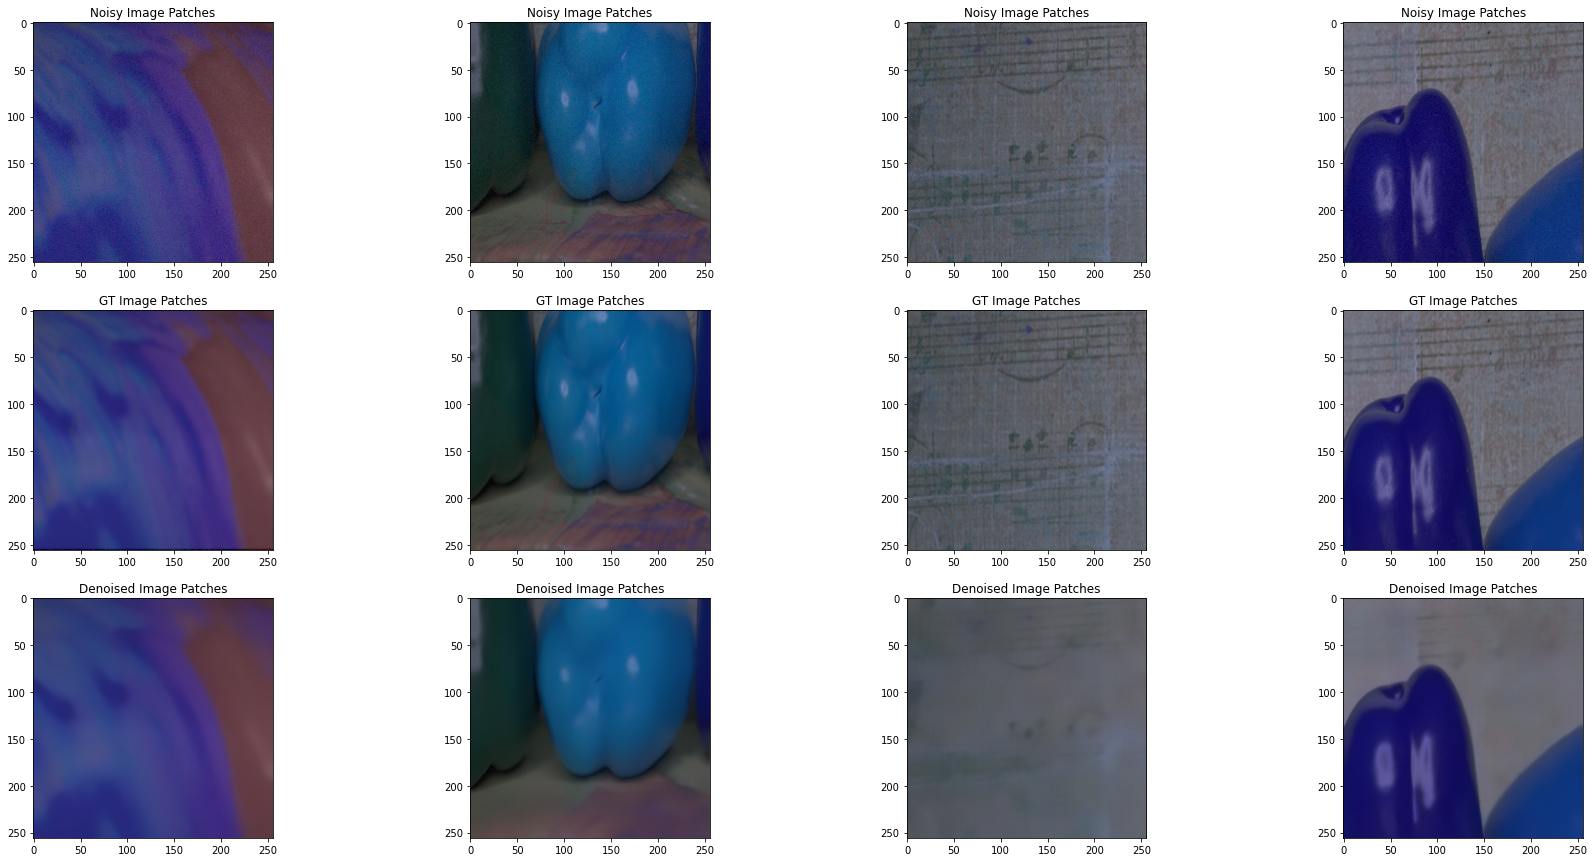

In [150]:
## https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Non-local_Means_Denoising_Algorithm_Noise_Reduction.php

no_of_cols = 4

fig, axs = plt.subplots(3,no_of_cols,figsize=(30,15))
r = random.sample(range(0, rows), no_of_cols)
c = random.sample(range(0, cols), no_of_cols)
PSNR_nsy=[]
PSNR_de_nsy=[]

for i in range(no_of_cols):
  img1 = patches_nsy[r[i]][c[i]][0]
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = patches_gt[r[i]][c[i]][0]
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  axs[0][i].imshow(img1)
  axs[0][i].set_title('Noisy Image Patches')

  axs[1][i].imshow(img2)
  axs[1][i].set_title('GT Image Patches')
  # Denoising
  dst = cv2.fastNlMeansDenoisingColored(img1,None,10,10,7,21)
  axs[2][i].imshow(dst)
  axs[2][i].set_title('Denoised Image Patches')
  
  PSNR_nsy.append(psnr(img1,img2))
  PSNR_de_nsy.append(psnr(img1,dst))

In [147]:
improvement = [x1 - x2 for (x1, x2) in zip(PSNR_de_nsy, PSNR_nsy)]

In [148]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("PSNR before denoising",PSNR_nsy)
x.add_column("PSNR after denoising",PSNR_de_nsy)
x.add_column("PSNR Improvement",improvement)
print(x)  

+-----------------------+----------------------+---------------------+
| PSNR before denoising | PSNR after denoising |   PSNR Improvement  |
+-----------------------+----------------------+---------------------+
|   32.29994724532835   |  31.11855638674038   | -1.1813908585879673 |
|   32.75110444069533   |  32.40125205138466   | -0.3498523893106693 |
|   33.52602893219097   |  31.524793315181366  |  -2.001235617009602 |
|   33.90262564565009   |  31.692777090828322  |  -2.209848554821768 |
+-----------------------+----------------------+---------------------+


In [133]:
sample['Ground Truth Images'][0]

'../data/raw/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG'

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
path = sample['Ground Truth Images'].iloc[0]
img = cv2.imread(path)
b,g,r = cv2.split(img)           # get b,g,r
rgb_img = cv2.merge([r,g,b])     # switch it to rgb

# Denoising
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

b,g,r = cv2.split(dst)           # get b,g,r
rgb_dst = cv2.merge([r,g,b])     # switch it to rgb

plt.subplot(211),plt.imshow(rgb_img)
plt.subplot(212),plt.imshow(rgb_dst)
plt.show()

NameError: name 'sample' is not defined

## Observations:<br>

As you can see, the NLM filter is able to denoise the images to some extent. But it smoothens many details that are present in the ground truth images leading to loss of important informations that should have been retained. Also, when noise is too high NLM fails to provide good results. <br>

Thus we can conclude, there is a need of using more advanced deep learning techniques for image denoising tasks. 

## Creating Dataset for modeling using custom data generators in Keras 

In [152]:
X_train_patches, y_train_patches = pickle.load(open('../data/interim/train_data.pkl', 'rb'))
X_test_patches,y_test_patches = pickle.load(open('../data/interim/test_data.pkl', 'rb'))

In [153]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)

(2048, 256, 256, 3)
(2048, 256, 256, 3)
(512, 256, 256, 3)
(512, 256, 256, 3)


## References
- https://github.com/sharathsolomon/ImageDenoising/blob/main/ImageDenoising.ipynb